## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df =  pd.read_csv(r"../data/MIT-BIH Arrhythmia Database.csv")

## Feature Engineering

In [5]:
#create other features derived form thses columsn
df['rr_ratio'] = df['0_post-RR'] / df['0_pre-RR']  # Heart rate variability
df['qt_corrected'] = df['0_qt_interval'] / np.sqrt(df['0_post-RR'])  # QTc
df['beat_consistency'] = abs(df['0_qrs_interval'] - df['1_qrs_interval']) # Beat-to-beat variation
# Measure beat-to-beat variability by computing the standard deviation of pre-RR and post-RR intervals (HRV indicator)
df['rr_std'] = df[['0_pre-RR', '0_post-RR']].std(axis=1)
# Compute the difference in QT intervals between two consecutive beats to detect repolarization instability
df['qt_diff'] = df['0_qt_interval'] - df['1_qt_interval']

## Handling Missing Data & outliers

In [6]:
missing_summary = df.isnull().sum()
print("Missing Values per column: ")
print(missing_summary[missing_summary > 0])

Missing Values per column: 
Series([], dtype: int64)


no missing value

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
for col in df.select_dtypes('number'):
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75) 
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Outliers of {col} is = {len(outliers)}")

Outliers of record is = 0
Outliers of 0_pre-RR is = 2134
Outliers of 0_post-RR is = 2201
Outliers of 0_pPeak is = 3331
Outliers of 0_tPeak is = 385
Outliers of 0_rPeak is = 5383
Outliers of 0_sPeak is = 2
Outliers of 0_qPeak is = 8548
Outliers of 0_qrs_interval is = 1351
Outliers of 0_pq_interval is = 2686
Outliers of 0_qt_interval is = 7496
Outliers of 0_st_interval is = 15786
Outliers of 0_qrs_morph0 is = 8548
Outliers of 0_qrs_morph1 is = 10215
Outliers of 0_qrs_morph2 is = 3631
Outliers of 0_qrs_morph3 is = 2177
Outliers of 0_qrs_morph4 is = 3510
Outliers of 1_pre-RR is = 2134
Outliers of 1_post-RR is = 2201
Outliers of 1_pPeak is = 6643
Outliers of 1_tPeak is = 1947
Outliers of 1_rPeak is = 10465
Outliers of 1_sPeak is = 7802
Outliers of 1_qPeak is = 4100
Outliers of 1_qrs_interval is = 3203
Outliers of 1_pq_interval is = 4479
Outliers of 1_qt_interval is = 2142
Outliers of 1_st_interval is = 8861
Outliers of 1_qrs_morph0 is = 4100
Outliers of 1_qrs_morph1 is = 4088
Outliers of 1_

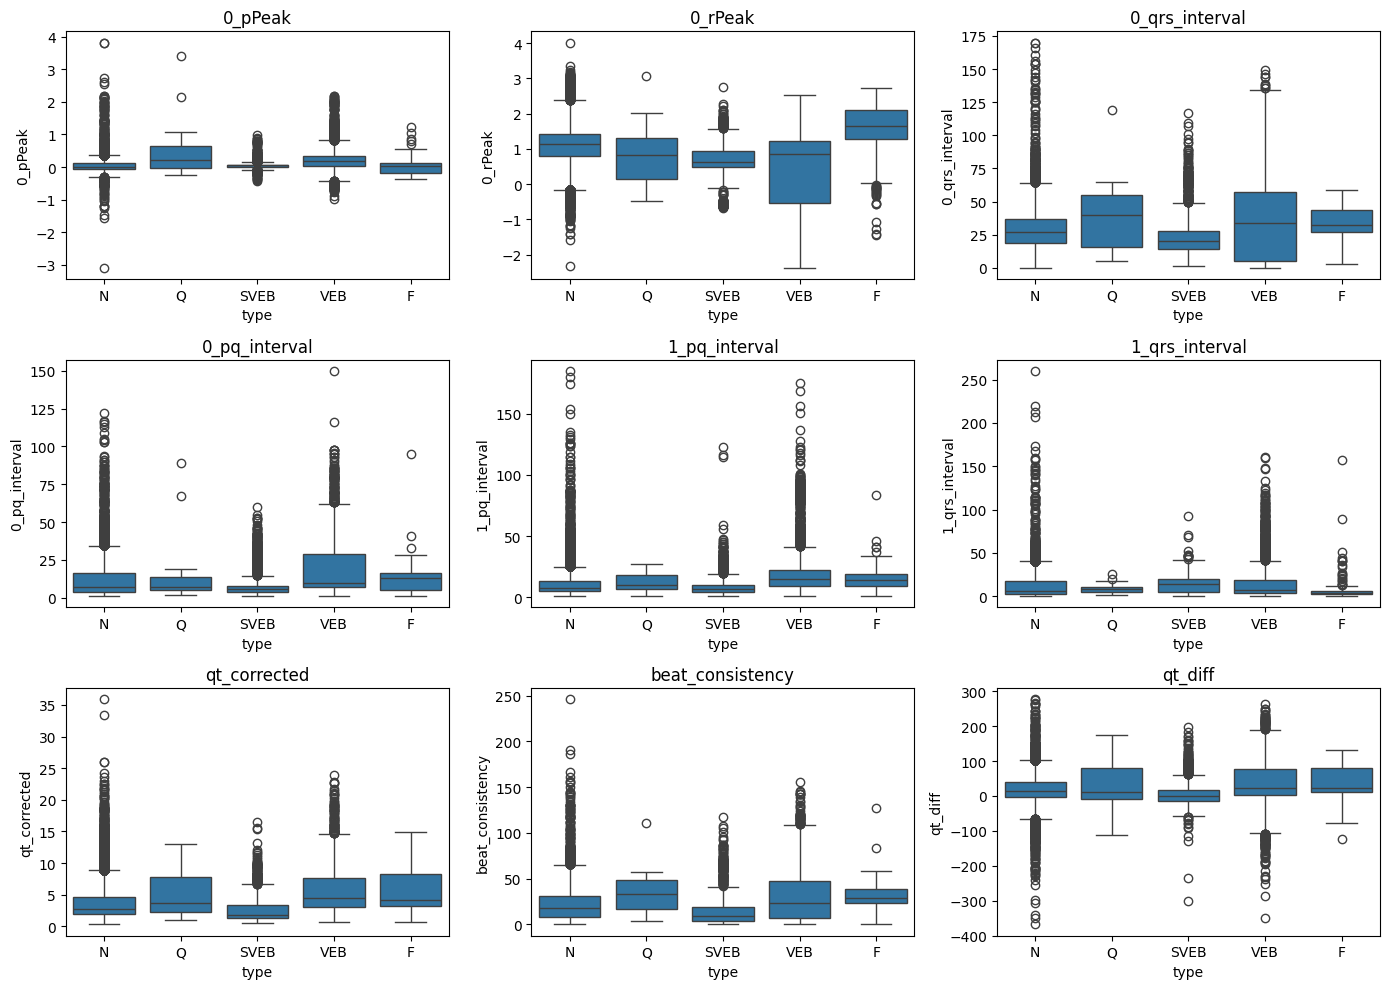

In [9]:
outlier_columns_to_handle = [
    '0_pPeak',         # قمة الموجة P - ممكن تكون شاذة بسبب noise
    '0_rPeak',         # R Peak - توزيعها بيكون قوي، بس ممكن فيه artifacts
    '0_qrs_interval',  # مدة QRS - لو توزيعها skewed جدًا
    '0_pq_interval',   # ممكن تتأثر بحالات خطأ
    '1_pq_interval',   # نفس الفكرة
    '1_qrs_interval',
    'qt_corrected',    # انت عملتله feature engineering - خلي نسخة منه
    'beat_consistency',# اختلاف beat ل beat - المفروض مش يبقى ضخم جدًا
    'qt_diff'          # مشتق - فلو طالع شاذ جدًا ممكن يبقى نتيجة شذوذ أصلي
]

columns_to_leave = [
    '0_pre-RR', '0_post-RR',      # معدل نبض – ممكن فعليًا يبقى منخفض جدًا أو مرتفع جدًا
    '1_pre-RR', '1_post-RR',      # نفس الفكرة
    'rr_ratio',                   # ممكن يدل على فرق كبير في معدل ضربات القلب
    '1_rPeak', '1_sPeak',         # سعة الذروة R/S – لو فعليًا القلب ضعيف أو قوي
    '1_tPeak', '0_tPeak',         # T wave – ممكن تتغير فعليًا مع المرض
]

plt.figure(figsize=(14, 10))
for i, col in enumerate(outlier_columns_to_handle, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(data=df, x='type', y=df[col])
    plt.title(col)
plt.tight_layout()  
plt.show()

### 📊 تحليل القيم الشاذة حسب نوع نبضة القلب

المخططات الصندوقية في الأعلى توضح توزيع مجموعة من الخصائص (features) المستخرجة من إشارات القلب (ECG) عبر أنواع مختلفة من نبضات القلب (`N`, `Q`, `SVEB`, `VEB`, `F`). الهدف منها هو التعرف على وجود القيم الشاذة (Outliers) وكيف تختلف باختلاف نوع النبضة.

- بعض الخصائص مثل `qt_diff` و `beat_consistency` و `1_qrs_interval` تُظهر عددًا كبيرًا من القيم الشاذة، خاصة في النبضات غير الطبيعية مثل `VEB` و `F`.
- في المقابل، خصائص مثل `0_pPeak` و `0_rPeak` توزيعها أقرب للطبيعي، لكنها ما زالت تحتوي على بعض القيم الخارجة عن النطاق المتوقع.
- من المهم ملاحظة أن هذه القيم الشاذة قد تنتج عن ضوضاء القياس أو اختلافات فسيولوجية طبيعية بين المرضى.

📌 **الخلاصة**: التعامل مع القيم الشاذة أمر ضروري قبل التدريب، وده ممكن يشمل تقنيات مثل:

> المعالجة المناسبة للقيم الشاذة قد تساهم في تحسين دقة النموذج واستقراره.

In [10]:
y = df['type']
df = df.drop(columns=['type'])

In [12]:
from sklearn.preprocessing import LabelEncoder
import joblib

le = LabelEncoder()
y_encoded = le.fit_transform(y)

joblib.dump(le, r"../models/label_encoder.pkl")

['../models/label_encoder.pkl']

# Data preprocessing Pipeline

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd

# ================== Transformation Functions ==================

def rr_ratio_func(x):
    if isinstance(x, pd.DataFrame):
        x = x.to_numpy()
    denom = np.where(x[:, [1]] == 0, np.nan, x[:, [1]])
    return x[:, [0]] / denom

def qt_corrected_func(x):
    if isinstance(x, pd.DataFrame):
        x = x.to_numpy()
    return x[:, [0]] / np.sqrt(x[:, [1]])

def beat_consistency_func(x):
    if isinstance(x, pd.DataFrame):
        x = x.to_numpy()
    return abs(x[:, [0]] - x[:, [1]])

def rr_std_func(x):
    if isinstance(x, pd.DataFrame):
        x = x.to_numpy()
    return np.std(x, axis=1, keepdims=True)

def qt_diff_func(x):
    if isinstance(x, pd.DataFrame):
        x = x.to_numpy()
    return x[:, [0]] - x[:, [1]]

# ================== Safe Log Function ==================

def safe_log1p(x):
    x = np.where(x <= -1, 0, x)
    return np.log1p(x)

# ================== Feature Name Out Functions ==================

def get_rr_ratio_name(_): return ["rr_ratio"]
def get_qt_corrected_name(_): return ["qt_corrected"]
def get_beat_consistency_name(_): return ["beat_consistency"]
def get_rr_std_name(_): return ["rr_std"]
def get_qt_diff_name(_): return ["qt_diff"]
def get_log_trans_names(transformer, input_features): return input_features

# ================== Pipelines for Derived Features ==================

def rr_ratio_pipeline():
    return make_pipeline(
        FunctionTransformer(rr_ratio_func, feature_names_out=get_rr_ratio_name),
        StandardScaler()
    )

def qt_corrected_pipeline():
    return make_pipeline(
        FunctionTransformer(qt_corrected_func, feature_names_out=get_qt_corrected_name),
        FunctionTransformer(safe_log1p, inverse_func=np.expm1, check_inverse=False),
        StandardScaler()
    )

def beat_consistency_pipeline():
    return make_pipeline(
        FunctionTransformer(beat_consistency_func, feature_names_out=get_beat_consistency_name),
        FunctionTransformer(safe_log1p, inverse_func=np.expm1, check_inverse=False),
        StandardScaler()
    )

def rr_std_pipeline():
    return make_pipeline(
        FunctionTransformer(rr_std_func, feature_names_out=get_rr_std_name),
        StandardScaler()
    )

def qt_diff_pipeline():
    return make_pipeline(
        FunctionTransformer(qt_diff_func, feature_names_out=get_qt_diff_name),
        FunctionTransformer(safe_log1p, inverse_func=np.expm1, check_inverse=False),
        StandardScaler()
    )

# ================== Log + Scaling Pipeline ==================

log_pipeline = make_pipeline(
    FunctionTransformer(
        safe_log1p,
        inverse_func=np.expm1,
        feature_names_out=get_log_trans_names,
        check_inverse=False
    ),
    StandardScaler()
)

# ================== Default Scaling Pipeline ==================

default_pipeline = make_pipeline(StandardScaler())

# ================== Full Preprocessing Pipeline ==================

# Define the columns that need log scaling
outlier_columns_to_handle = [
    '0_pPeak', '0_tPeak', '0_rPeak', '0_sPeak', '0_qPeak',
    '1_pPeak', '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak'
]

preprocessing = ColumnTransformer([
    ("rr_ratio", rr_ratio_pipeline(), ["0_post-RR", "0_pre-RR"]),
    ("qt_corrected", qt_corrected_pipeline(), ["0_qt_interval", "0_post-RR"]),
    ("beat_consistency", beat_consistency_pipeline(), ["0_qrs_interval", "1_qrs_interval"]),
    ("rr_std", rr_std_pipeline(), ["0_pre-RR", "0_post-RR"]),
    ("qt_diff", qt_diff_pipeline(), ["0_qt_interval", "1_qt_interval"]),
    ("log", log_pipeline, outlier_columns_to_handle)
], remainder=default_pipeline, force_int_remainder_cols=False)

In [43]:
preprocessing.fit(df)

ColumnTransformer(force_int_remainder_cols=False,
                  remainder=Pipeline(steps=[('standardscaler',
                                             StandardScaler())]),
                  transformers=[('rr_ratio',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function get_rr_ratio_name at 0x00000115CEFE7CE0>,
                                                                      func=<function rr_ratio_func at 0x00000115CEFA6A20>)),
                                                 ('standardscaler',
                                                  StandardScaler())...
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(check_inverse=False,
                                                                      feature_names_out=<function get_log_trans_names at 0x00000115CEFE63E0>,
                                                                      func=<function safe_log1p at 0x00000115CEFE6AC0>,
                                                                      inverse_func=<ufunc 'expm1'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['0_pPeak', '0_tPeak', '0_rPeak', '0_sPeak',
                                  '0_qPeak', '1_pPeak', '1_tPeak', '1_rPeak',
                                  '1_sPeak', '1_qPeak'])])

In [44]:
joblib.dump(preprocessing, r"../models/preprocessing_pipeline.pkl")

['../models/preprocessing_pipeline.pkl']

## Handling Class Imbalance
We will use SMOTE (Synthetic Minority Over-sampling Technique) to handle the class imbalance problem
by generating synthetic samples for the minority classes.